# \<Title>
## Introduction

Abalones are sea snails known for being seafood delicacies. The price of an abalone is positively correlated with its age. The standard method of determining an abalone's age is tedious and laborious. We aim to streamline this process using predictive modeling.

***Question:***
How does the number of rings an abalone has, and consequently its age, depend on its physical dimensions and weight?

In this project, we will be developing a model that predicts the age of an abalone using easily measurable physical traits. The data set we are using is from the UCI Machine Learning Repository. It contains comma-separated values with no headers and contains 4177 instances. It includes the ***sex, length (mm), diameter (mm), height (mm), whole weight (grams), shucked weight (grams, meat weight), viscera weight (grams, gut weight after bleeding), shell weight (grams, after drying), and number of rings*** of a given abalone. The range of the continuous variables has been pre-scaled by dividing by 200. Our target variable is the number of rings.

## Methods and Results

### \<Will need to add more details>

#### Question: "describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis"

Even though the number of rings is not a continuous value, since we will be predicting age (which is continuous), regression should be an appropriate method of prediction. Approximate age can be found in years by adding 1.5 to the number of rings our model predicts. We may also use classification later on to explore different results.

Diameter, height, and whole weight will be our main predictors. This is to avoid any bias created by using four weight predictors and two length predictors. As seen in our graphs, there is an overlap of distributions and strong linear relations between similar variables. Sex will not be used as it is categorical instead of numerical.

### Updating altair:

In [1]:
pip install -U altair

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import altair as alt
import numpy as np
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simplify working with large datasets in Altair
alt.data_transformers.disable_max_rows()

# Output dataframes instead of arrays
set_config(transform_output="pandas")

from sklearn.model_selection import GridSearchCV, train_test_split
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Reading data from web:

In [3]:
url='https://drive.google.com/file/d/1nPiV8p49ZExhs_C8TnExmvSFRQOzKi90/view?usp=sharing'
file_id = url.split('/')[-2]
read_url='https://drive.google.com/uc?id=' + file_id

abalone_data=pd.read_csv(read_url, 
                         header=None, 
                         names=[
    'sex','length','diameter','height','weight_whole','weight_shucked','weight_viscera','weight_shell','rings']
)
print('Table 1: Abalone Dataframe')
abalone_data.head(10)

Table 1: Abalone Dataframe


,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


The data is already fairly tidy. We have named the columns to match their respective measurements.

### Splitting data:

In [4]:
abalone_train, abalone_test = train_test_split(
    abalone_data, train_size=0.75, random_state = 2000
)

### Summary tables:

#### Basic Shape:

In [5]:
abalone_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3132 entries, 2153 to 2998
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             3132 non-null   object 
 1   length          3132 non-null   float64
 2   diameter        3132 non-null   float64
 3   height          3132 non-null   float64
 4   weight_whole    3132 non-null   float64
 5   weight_shucked  3132 non-null   float64
 6   weight_viscera  3132 non-null   float64
 7   weight_shell    3132 non-null   float64
 8   rings           3132 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 244.7+ KB


#### Describing Variables:

In [6]:
variable_info = {
    'column':['sex','length','diameter','height','weight_whole','weight_shucked','weight_viscera','weight_shell','rings'],
    'dtype':[
        'nominal (object)','continuous (float)','continuous (float)','continuous (float)','continuous (float)','continuous (float)','continuous (float)','continuous (float)','integer'
    ],
    'measurement':['Male(M), Female(F) or Infant(I)','mm','mm','mm','grams','grams','grams','grams','']
}
variable_info=pd.DataFrame(variable_info)
print('Table 2: Variable Information')
variable_info

Table 2: Variable Information


,column,dtype,measurement
0,sex,nominal (object),"Male(M), Female(F) or Infant(I)"
1,length,continuous (float),mm
2,diameter,continuous (float),mm
3,height,continuous (float),mm
4,weight_whole,continuous (float),grams
5,weight_shucked,continuous (float),grams
6,weight_viscera,continuous (float),grams
7,weight_shell,continuous (float),grams
8,rings,integer,


#### Summary Statistics for Numerical Columns:

In [7]:
summary_stats=abalone_train.drop(columns='sex').agg({'max','min','std','mean',})
print('Table 3: Summary Statistics')
summary_stats


Table 3: Summary Statistics


,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
min,0.075000,0.055000,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000
mean,0.525945,0.409420,0.140091,0.836755,0.362685,0.182083,0.241312,9.963282
max,0.815000,0.650000,0.515000,2.657000,1.488000,0.641500,1.005000,29.000000
std,0.119671,0.098797,0.038640,0.490454,0.222207,0.109365,0.140216,3.225516


#### Distribution of Target Variable:

In [8]:
ring_count=abalone_train['rings'].value_counts().reset_index()
ring_count.columns=['rings','count']
ring_count=ring_count.sort_values(by=['rings']).reset_index().drop(columns='index')
print('Table 3: Distribution of Target Variable (Rings)')
ring_count


Table 3: Distribution of Target Variable (Rings)


,rings,count
0,1,1
1,2,1
2,3,11
3,4,39
4,5,86
5,6,189
6,7,289
7,8,414
8,9,541
9,10,469


### Visualization

#### Distribution of Possible Predictors and Target Variable:

In [9]:
length_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("length").title("Length (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

diameter_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("diameter").title("Diameter (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

height_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("height").title("Height (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

weight_whole_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("weight_whole").title("Whole Weight (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

weight_shucked_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("weight_shucked").title("Shucked Weight (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

weight_viscera_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("weight_viscera").title("Viscera Weight (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

weight_shell_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("weight_shell").title("Shell Weight (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)

rings_distribution = alt.Chart(abalone_train).mark_bar().encode(
    x = alt.X("rings").title("Number of rings (scaled and binned)").bin(maxbins=30),
    y = alt.Y("count()").title("Count")
)
all_distribution= alt.vconcat(
    alt.hconcat(length_distribution, diameter_distribution, height_distribution),
    alt.hconcat(weight_whole_distribution, weight_shucked_distribution, weight_viscera_distribution),
    alt.hconcat(weight_shell_distribution, rings_distribution)
).properties(
    title={
        "text": "Fig 1: Distributions of All Variables", 
        "fontSize": 16,
        'anchor':'middle'
    }
)
all_distribution

alt.VConcatChart(...)

#### Relationship Between Possible Predictors and Target:

In [10]:
length_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("length").title("Length (scaled)"),
    y = alt.Y("rings").title("Number of rings")
)

diameter_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("diameter").title("Diameter (scaled)"),
    y = alt.Y("rings").title("Number of rings")
)

height_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("height").title("Height (scaled)"),
    y = alt.Y("rings").title("Number of rings")
)

weight_whole_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_whole").title("Whole Weight (scaled)"),
    y = alt.Y("rings").title("Number of rings")
)

weight_shucked_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_shucked").title("Shucked Weight (scaled)"),
    y = alt.Y("rings").title("Number of rings")
)

weight_viscera_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_viscera").title("Viscera Weight (scaled)"),
    y = alt.Y("rings").title("Number of rings")
)

weight_shell_v_rings = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_shell").title("Shell Weight (scaled)"),
    y = alt.Y("rings").title("Number of rings")
)

alt.vconcat(
    alt.hconcat(length_v_rings, diameter_v_rings, height_v_rings),
    alt.hconcat(weight_whole_v_rings, weight_shucked_v_rings, weight_viscera_v_rings),
    weight_shell_v_rings
).properties(
    title={
        "text": "Fig 2: Relationship Between Possible Predictors and Target",
        "fontSize": 16,
        'anchor':'middle'
    }
)

alt.VConcatChart(...)

#### Relationship between similar predictors:

In [11]:
length_v_diameter = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("length").title("Length (scaled)"),
    y = alt.Y("diameter").title("Diameter (scaled)")
)

whole_weight_v_shucked_weight = alt.Chart(abalone_train).mark_point(opacity=0.3).encode(
    x = alt.X("weight_whole").title("Whole weight (scaled)"),
    y = alt.Y("weight_viscera").title("Shucked weight (scaled)")
)
alt.hconcat(
    length_v_diameter,whole_weight_v_shucked_weight
).properties(
    title={
        "text": 'Fig 3: High Correlation between Similar Predictors',
        "fontSize": 16,
        'anchor':'middle'
    }
)


alt.HConcatChart(...)

### Data Analysis

Using the above preliminary exploratory analysis, we can observe that certain subsets of predictors exhibit very similar relationships with the target variable. This is due to the close correlations observed between the variables such as: length and diameter, as well as amongst the weight-related variables.

Thus, in order to eliminate issues arising from multicollinearity that can make our regression models unreliable, we will narrow our predictor variables down to diameter, height, and whole weight.

In the following, we will create a K-nearest neighbors regression model and a linear regression model.

#### K-nearest Neighbors Regression:

In [12]:
# Since we've already split the data, we can use abalone_test and abalone_train

# ASSIGNING VARIABLES TO THE PREDICTORS AND TARGET
X_train = abalone_train[["diameter", "height", "weight_whole"]]
y_train = abalone_train["rings"]

X_test = abalone_test[["diameter", "height", "weight_whole"]]
y_test = abalone_test["rings"]

In [13]:
# CREATING THE PIPELINE
abalone_pipe = make_pipeline((StandardScaler()), KNeighborsRegressor())

In [14]:
# CROSS VALIDATION 
# could explain why a cross-validation of 5 is chosen, but I think it's pretty common
abalone_cv = pd.DataFrame(
    cross_validate(
        estimator = abalone_pipe, 
        cv = 5,
        X = X_train,
        y = y_train,
        scoring = "neg_root_mean_squared_error",
        return_train_score=True,
    )
)

In [15]:
# GETTING THE RESULTS
# Do we need to explain why a range of 200 was chosen...?
param_grid = {
    "kneighborsregressor__n_neighbors": range(1, 201, 1)
}

abalone_tuned = GridSearchCV(
    estimator = abalone_pipe,
    cv = 5,
    param_grid = param_grid,
    n_jobs = -1,
    scoring = "neg_root_mean_squared_error"
)

abalone_results = pd.DataFrame(
    abalone_tuned.fit(
        abalone_train[["diameter", "height", "weight_whole"]],
        abalone_train["rings"]
    ).cv_results_
)
abalone_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsregressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007496,0.000661,0.005297,0.000208,1,{'kneighborsregressor__n_neighbors': 1},-3.369106,-3.471920,-3.624332,-3.329604,-3.484333,-3.455859,0.102877,200
1,0.006959,0.000108,0.007929,0.004908,2,{'kneighborsregressor__n_neighbors': 2},-2.894682,-3.068399,-3.116995,-3.000200,-3.006582,-3.017372,0.074823,199
2,0.007172,0.000240,0.006475,0.001447,3,{'kneighborsregressor__n_neighbors': 3},-2.747705,-2.891290,-2.942503,-2.832722,-2.893384,-2.861521,0.066698,198
3,0.008744,0.001051,0.007215,0.000632,4,{'kneighborsregressor__n_neighbors': 4},-2.681212,-2.812665,-2.788254,-2.755386,-2.821093,-2.771722,0.050688,197
4,0.007110,0.000174,0.014573,0.016239,5,{'kneighborsregressor__n_neighbors': 5},-2.666168,-2.750740,-2.711247,-2.697011,-2.779225,-2.720878,0.039879,196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.006915,0.000119,0.031348,0.002884,196,{'kneighborsregressor__n_neighbors': 196},-2.465444,-2.556618,-2.572303,-2.582624,-2.547998,-2.544997,0.041555,160
196,0.007580,0.000506,0.041100,0.012904,197,{'kneighborsregressor__n_neighbors': 197},-2.464632,-2.557531,-2.572494,-2.582604,-2.547367,-2.544926,0.041932,158
197,0.007539,0.000425,0.040138,0.008884,198,{'kneighborsregressor__n_neighbors': 198},-2.465971,-2.557718,-2.572799,-2.582757,-2.546992,-2.545248,0.041495,163
198,0.007552,0.000926,0.033467,0.004418,199,{'kneighborsregressor__n_neighbors': 199},-2.466012,-2.557935,-2.572461,-2.583961,-2.547960,-2.545666,0.041678,164


In [16]:
# Obtaining best knn and best RMSPE score
abalone_min = abalone_tuned.best_params_
abalone_best_RMSPE = -abalone_tuned.best_score_

In [17]:
abalone_min

{'kneighborsregressor__n_neighbors': 82}

In [18]:
abalone_best_RMSPE

2.530462177016068

In [19]:
#Predicting values 
abalone_predictions = abalone_test.assign(
    predicted_rings = abalone_tuned.predict(abalone_test[["diameter", "height", "weight_whole"]])
)
abalone_predictions

,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings,predicted_rings
1413,M,0.675,0.545,0.185,1.7375,0.8760,0.3135,0.4690,13,12.256098
3329,F,0.545,0.435,0.150,0.6855,0.2905,0.1450,0.2250,10,10.329268
2994,M,0.610,0.475,0.175,1.0240,0.4090,0.2610,0.3220,9,11.329268
1243,I,0.385,0.280,0.085,0.2175,0.0970,0.0380,0.0670,8,7.146341
2796,M,0.630,0.525,0.195,1.3135,0.4935,0.2565,0.4650,10,12.146341
...,...,...,...,...,...,...,...,...,...,...
47,F,0.460,0.375,0.120,0.4605,0.1775,0.1100,0.1500,7,8.951220
3632,I,0.300,0.225,0.075,0.1345,0.0570,0.0280,0.0440,5,6.195122
3068,M,0.650,0.510,0.175,1.3165,0.6345,0.2605,0.3640,12,11.207317
3845,M,0.455,0.350,0.105,0.4160,0.1625,0.0970,0.1450,11,8.353659


In [20]:
# Testing on unseen data
abalone_summary = mean_squared_error(
    y_true = abalone_test["rings"],
    y_pred = abalone_predictions["predicted_rings"]
)**(1/2)

abalone_summary

# Testing on unseen data actually had a BETTER RMSPE score!

2.4888979256328763

#### Linear Regression:

In [21]:
lr = LinearRegression()

abalone_fit_lr = lr.fit(X_train, y_train)

print(abalone_fit_lr.coef_)
print(abalone_fit_lr.intercept_)

[ 7.63777791 37.83501282 -0.49490378]
1.9499880400717888


This shows that the equation with slopes/coefficients for each predictor and with the intercept would be
$rings = 1.9499880400717888 + 7.63777791 * diameter + 37.83501282 * height -0.49490378 * weight\_whole$

In [22]:
#Predicting values
abalone_predictions_lr = abalone_test.assign(
    predicted_rings = abalone_fit_lr.predict(abalone_test[["diameter", "height", "weight_whole"]])
)
abalone_predictions_lr

,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings,predicted_rings
1413,M,0.675,0.545,0.185,1.7375,0.8760,0.3135,0.4690,13,12.252159
3329,F,0.545,0.435,0.150,0.6855,0.2905,0.1450,0.2250,10,10.608417
2994,M,0.610,0.475,0.175,1.0240,0.4090,0.2610,0.3220,9,11.692278
1243,I,0.385,0.280,0.085,0.2175,0.0970,0.0380,0.0670,8,7.196900
2796,M,0.630,0.525,0.195,1.3135,0.4935,0.2565,0.4650,10,12.687593
...,...,...,...,...,...,...,...,...,...,...
47,F,0.460,0.375,0.120,0.4605,0.1775,0.1100,0.1500,7,9.126453
3632,I,0.300,0.225,0.075,0.1345,0.0570,0.0280,0.0440,5,6.439549
3068,M,0.650,0.510,0.175,1.3165,0.6345,0.2605,0.3640,12,11.814841
3845,M,0.455,0.350,0.105,0.4160,0.1625,0.0970,0.1450,11,8.390007


In [23]:
# RMSPE to see How well the model predicts on data it was not trained with
abalone_rmspe_lr = mean_squared_error(
    y_true = abalone_test["rings"],
    y_pred = abalone_predictions_lr["predicted_rings"]
)**(1/2)
abalone_rmspe_lr

2.7885659244182652

We can see that KNN regression has a lower RMSPE, which makes it a better choice in this case.

### Visualization of Models


#### \<Insert actual visualization code below this>

Our main visualization is a 3-dimensional scatter plot with the predictors on the x, y, and color axes and the target on the z-axis. This will give us an idea of how our model is working. Using bar graphs to show comparisons can also be effective.

We will also use a confusion matrix to determine the range of accuracy.

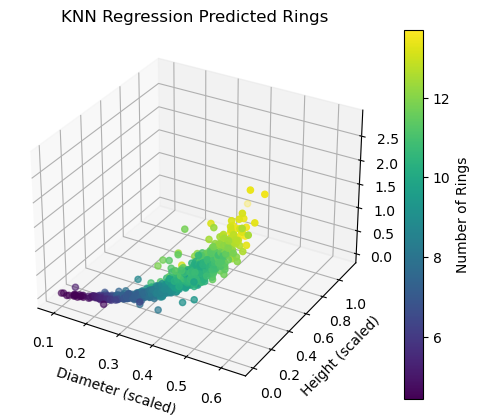

In [50]:
# Creating a 3D plot with color representing the target variable
fig = plt.figure()
ax = plt.axes(projection='3d')

sc = ax.scatter(abalone_predictions["diameter"], abalone_predictions["height"], abalone_predictions["weight_whole"], c=abalone_predictions["predicted_rings"])

ax.set_xlabel("Diameter (scaled)")
ax.set_ylabel("Height (scaled)")
ax.set_zlabel("Whole Weight (scaled)")
ax.set_title("KNN Regression Predicted Rings") #not sure what to title this

cbar = plt.colorbar(sc)
cbar.set_label("Number of Rings")

plt.show()

## Discussion

### Summary of Findings

#### \<Insert summary here or below>

### Expected Outcomes VS Findings

As we can see in the preliminary graphs, the number of rings is positively related to all our predictors. We expect our model to determine the relation between the predictors and the target to be linear and positive. One concern is that the accuracy of the model may decrease when predicting above 7 rings due to the weakened relationship between weight and rings.

#### \<Above was the "expected outcomes" Add discussion about how it relates to findings>

### Significance and Impact of Findings

#### \<add more to talk about the findings and impact of that>
Creating a model to easily and quickly determine the age of an abalone would greatly help with sorting and pricing abalones. This would not only benefit farmers, but also consumers, who can now purchase based on age (abalone tastes better with age).

### Future topics of research and questions:
How do abalone prices depend on age?
What is the optimal age for an abalone to be sold on the market to maximize profits?

## References

### Dataset
Nash,Warwick, Sellers,Tracy, Talbot,Simon, Cawthorn,Andrew, and Ford,Wes. (1995). Abalone. UCI Machine Learning Repository. https://doi.org/10.24432/C55C7W.

### Other Sources
Aquaculture Stewardship Council. (2023, June 26). Abalone. ASC International. https://asc-aqua.org/learn-about-seafood-farming/farmed-abalone/ 

Hossain, Md. M., &amp; Chowdhury, M. N. M. (2019, January 3). Econometric ways to estimate the age and price of abalone. Munich Personal RePEc Archive. https://mpra.ub.uni-muenchen.de/91210/ 

Huen, B. (2023, September 21). What exactly is abalone and how do you eat it?. Food Republic. https://www.foodrepublic.com/1294247/what-is-abalone-and-why-do-we-love-it/ 